num_encoder_tokens, num_decoder_tokens 358 789
{'COMMA': 0, 'a': 1, 'aboard': 2, 'above': 3, 'after': 4, 'again': 5, 'agree': 6, 'agreed': 7, 'ahead': 8, 'aim': 9, 'alive': 10, 'all': 11, 'alone': 12, 'am': 13, 'angry': 14, 'answer': 15, 'anyone': 16, 'are': 17, 'armed': 18, 'around': 19, 'ask': 20, 'attack': 21, 'awake': 22, 'away': 23, 'awesome': 24, 'awful': 25, 'back': 26, 'bad': 27, 'bald': 28, 'bark': 29, 'be': 30, 'beat': 31, 'beats': 32, 'bed': 33, 'beg': 34, 'birds': 35, 'bless': 36, 'blind': 37, 'bottoms': 38, 'bring': 39, 'broke': 40, 'busy': 41, 'call': 42, 'calm': 43, 'came': 44, 'can': 45, 'care': 46, 'careful': 47, 'cares': 48, 'carry': 49, 'catch': 50, 'check': 51, 'cheer': 52, 'cheers': 53, 'choose': 54, 'clean': 55, 'clear': 56, 'cold': 57, 'come': 58, 'content': 59, 'cook': 60, 'cool': 61, 'cop': 62, 'course': 63, 'crazy': 64, 'cried': 65, 'cringed': 66, 'cry': 67, 'cuff': 68, 'cured': 69, 'cute': 70, 'dark': 71, 'dead': 72, 'deaf': 73, 'deep': 74, 'did': 75, 'die': 

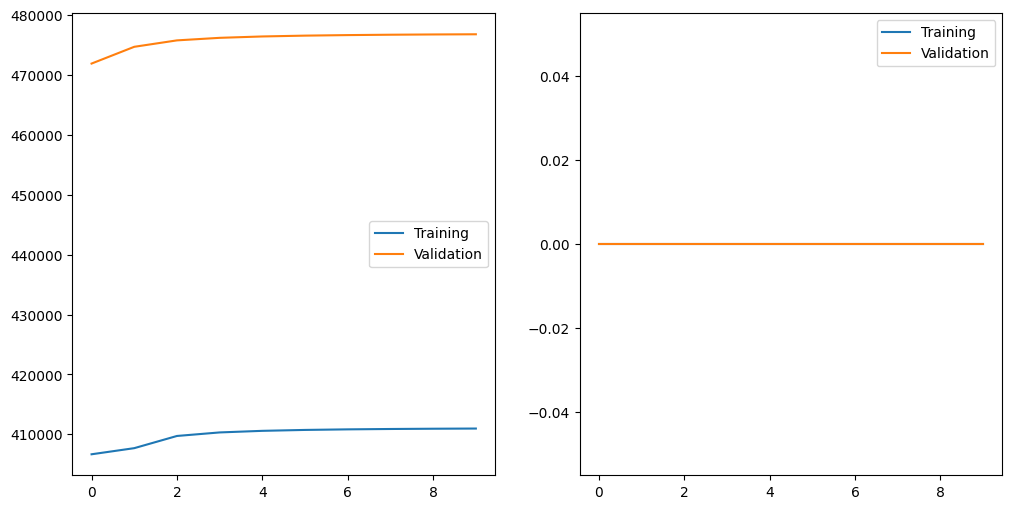

{'loss': [406677.1875, 407698.375, 409733.25, 410323.3125, 410588.875, 410740.90625, 410835.09375, 410897.1875, 410941.15625, 410972.09375], 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [471879.03125, 474677.125, 475748.8125, 476173.4375, 476402.75, 476541.3125, 476630.15625, 476692.625, 476736.46875, 476766.875], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
1/1 [==============================] - 0s 31ms/step
input : 64    we won
Name: eng, dtype: object
output true: 64    START_ nous gagnâmes _END
Name: fr, dtype: object
output predicted:  vos vos vos vos vos vos vos vos vos vos vos vos vos vos
1/1 [==============================] - 0s 18ms/step
input : 71    be calm
Name: eng, dtype: object
output true: 71    START_ soyez calmes  _END
Name: fr, dtype: object
output predicted:  vos vos vos vos vos vos vos vos vos vos vos vos vos vos
1/1 [==============================] - 0s 32ms/step
input : 185    we lost
Name: eng, dtype: object


In [84]:
import sys
import pandas as pd
import numpy as np
import string
from string import digits
import re
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt 

np.random.seed (seed=20303)


latent_dim  = 60

class Seq2Seq_Model:
    def __init__(self, num_encoder_tokens, num_decoder_tokens):
        self.num_encoder_tokens = num_encoder_tokens
        self.num_decoder_tokens = num_decoder_tokens
        self.model = None
        self.encoder_model = None 
        self.decoder_model = None
        self.get_models ()
        
    def get_models (self):
        
        encoder_inputs = Input(shape=(None,), name='Encoder-Inputs')
        en_x =  Embedding(self.num_encoder_tokens, latent_dim,name='Enc-Embedding')(encoder_inputs)
        encoder = LSTM(latent_dim, return_state=True,name='Encoder-LSTM')
        encoder_outputs, state_h, state_c = encoder(en_x)

        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        decoder_inputs = Input(shape=(None,), name='Decoder-Inputs')
        dex =  Embedding(num_decoder_tokens, latent_dim,name='Decoder-Embedding')
        final_dex= dex(decoder_inputs)

        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,name='Decoder-LSTM')
        decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)
        decoder_dense = Dense(num_decoder_tokens, activation='softmax',name='Decoder-Dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs,name='Seq2Seq-LSTM-Model')

        self.encoder_model = Model(encoder_inputs, encoder_states)
    
        decoder_state_input_h = Input(shape=(latent_dim,))
        decoder_state_input_c = Input(shape=(latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        final_dex2 = dex(decoder_inputs)
        decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
        decoder_states2 = [state_h2, state_c2]
        decoder_outputs2 = decoder_dense(decoder_outputs2)
        
        self.decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs2] + decoder_states2)
    
    def fit_model (self, encoder_input_data, decoder_input_data, decoder_target_data):
 
        self.model.compile(optimizer= 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        hist = self.model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=128, epochs=10,
         validation_split=0.20)
   
        return hist 


def decode_sequence(input_seq, M, input_token_index, target_token_index):
    target_token_index['START_'] = 1
    
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

    encoder_model =  M.encoder_model 
    decoder_model =  M.decoder_model 
     
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False

    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_char = reverse_target_char_index[sampled_token_index]
        #print("decoded", decoded_sentence)
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or len(decoded_sentence) > 52):
             stop_condition = True
    
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence




def get_data ():
    lines= pd.read_table('fra.txt', names=['eng','fr'])
    lines = lines[:1000]

    lines.eng=lines.eng.apply(lambda x: x.lower())
    lines.fr=lines.fr.apply(lambda x: x.lower())
    lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
    lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
    exclude = set(string.punctuation)
    lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
    lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))
    lines.fr = lines.fr.apply(lambda x : 'START_ '+ x + ' _END')
    
    return lines 

def preproc (lines):
    all_eng_words=set()
    for eng in lines.eng:
        for word in eng.split():
            if word not in all_eng_words:
                all_eng_words.add(word)

    all_french_words=set()
    for fr in lines.fr:
        for word in fr.split():
            if word not in all_french_words:
                all_french_words.add(word)

    input_words = sorted(list(all_eng_words))
    target_words = sorted(list(all_french_words))
    num_encoder_tokens = len(all_eng_words)
    num_decoder_tokens = len(all_french_words)

    input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
    target_token_index = dict([(word, i) for i, word in enumerate(target_words)])
    return num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index 



def get_vectorized (lines, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index):
    
    encoder_input_data = np.zeros((len(lines.eng), 6),dtype='float32')
    decoder_input_data = np.zeros((len(lines.fr), 12),dtype='float32')
    decoder_target_data = np.zeros((len(lines.fr), 12, num_decoder_tokens), dtype='float32')

    for i in range (0, len (lines.eng)):
        src = lines.eng[i].split(" ")
        src = [s for s in src if s]
        src = [input_token_index[x] for x in src]
        encoder_input_data[i, 0:len(src)] = src 

        tgt = lines.fr[i].split(" ")
        tgt = [t for t in tgt if t]
        tgt = [target_token_index[x] for x in tgt if x in target_token_index]
        decoder_input_data[i, 0:len(tgt)-1] = tgt[:-1] 
        for j in range (0, num_decoder_tokens):
            decoder_target_data[i, 1:len(tgt),j] = tgt[1:]
    return  encoder_input_data, decoder_input_data, decoder_target_data 


if __name__ == "__main__":

    lines = get_data ()
    
    num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index = preproc (lines)

    print("num_encoder_tokens, num_decoder_tokens",num_encoder_tokens, num_decoder_tokens)
    print(input_token_index)
    print(target_token_index )

    encoder_input_data, decoder_input_data, decoder_target_data =  get_vectorized (lines, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index)
 
    print("encoder", encoder_input_data)
    print("decoder", decoder_input_data)
    print("decoder out", np.sum (decoder_target_data))
    
    M = Seq2Seq_Model (num_encoder_tokens, num_decoder_tokens)

    print(M.model.summary())

    hist = M.fit_model (encoder_input_data, decoder_input_data, decoder_target_data)

    fig, axs = plt.subplots (1,2,figsize=(12,6))
    
    axs[0].plot(hist.history['loss'],label='Training')
    axs[0].plot(hist.history['val_loss'],label='Validation')
    axs[0].legend()
    
    axs[1].plot(hist.history['accuracy'],label='Training')
    axs[1].plot(hist.history['val_accuracy'],label='Validation')
    axs[1].legend()
    
    plt.show()
    print(hist.history)

    eng = lines.eng 

    for i in  [64, 71, 185]:
        src = lines.eng[i:i+1]
        tgt = lines.fr[i:i+1]
        input_seq = encoder_input_data[i: i + 1]
        decoded_sentence = decode_sequence(input_seq, M, input_token_index, target_token_index)
        print("input :", src)
        print("output true:", tgt)
        print("output predicted:", decoded_sentence) 
        print("================================")